In [1]:

import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from lpips import LPIPS


import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image
import models_mae


# Copyright (c) Meta Platforms, Inc. and affiliates.
# All rights reserved.

# This source code is licensed under the license found in the
# LICENSE file in the root directory of this source tree.
# --------------------------------------------------------
# References:
# timm: https://github.com/rwightman/pytorch-image-models/tree/master/timm
# DeiT: https://github.com/facebookresearch/deit
# --------------------------------------------------------

from functools import partial

import torch
import torch.nn as nn

from timm.models.vision_transformer import PatchEmbed, Block

from util.pos_embed import get_2d_sincos_pos_embed

class MaskedAutoencoderViT(nn.Module):
    """ Masked Autoencoder with VisionTransformer backbone
    """
    def __init__(self, img_size=224, patch_size=16, in_chans=3,
                 embed_dim=1024, depth=24, num_heads=16,
                 decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
                 mlp_ratio=4., norm_layer=nn.LayerNorm, norm_pix_loss=False):
        super().__init__()

        # --------------------------------------------------------------------------
        # MAE encoder specifics
        self.patch_embed = PatchEmbed(img_size, patch_size, in_chans, embed_dim)
        num_patches = self.patch_embed.num_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.blocks = nn.ModuleList([
            Block(embed_dim, num_heads, mlp_ratio, qkv_bias=True,  norm_layer=norm_layer)
            for i in range(depth)])
        self.norm = norm_layer(embed_dim)
        # --------------------------------------------------------------------------

        # --------------------------------------------------------------------------
        # MAE decoder specifics
        self.decoder_embed = nn.Linear(embed_dim, decoder_embed_dim, bias=True)

        self.mask_token = nn.Parameter(torch.zeros(1, 1, decoder_embed_dim))

        self.decoder_pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, decoder_embed_dim), requires_grad=False)  # fixed sin-cos embedding

        self.decoder_blocks = nn.ModuleList([
            Block(decoder_embed_dim, decoder_num_heads, mlp_ratio, qkv_bias=True, qk_scale=None, norm_layer=norm_layer)
            for i in range(decoder_depth)])

        self.decoder_norm = norm_layer(decoder_embed_dim)
        self.decoder_pred = nn.Linear(decoder_embed_dim, patch_size**2 * in_chans, bias=True) # decoder to patch
        # --------------------------------------------------------------------------

        self.norm_pix_loss = norm_pix_loss

        self.initialize_weights()

    def initialize_weights(self):
        # initialization
        # initialize (and freeze) pos_embed by sin-cos embedding
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        decoder_pos_embed = get_2d_sincos_pos_embed(self.decoder_pos_embed.shape[-1], int(self.patch_embed.num_patches**.5), cls_token=True)
        self.decoder_pos_embed.data.copy_(torch.from_numpy(decoder_pos_embed).float().unsqueeze(0))

        # initialize patch_embed like nn.Linear (instead of nn.Conv2d)
        w = self.patch_embed.proj.weight.data
        torch.nn.init.xavier_uniform_(w.view([w.shape[0], -1]))

        # timm's trunc_normal_(std=.02) is effectively normal_(std=0.02) as cutoff is too big (2.)
        torch.nn.init.normal_(self.cls_token, std=.02)
        torch.nn.init.normal_(self.mask_token, std=.02)

        # initialize nn.Linear and nn.LayerNorm
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            # we use xavier_uniform following official JAX ViT:
            torch.nn.init.xavier_uniform_(m.weight)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    def patchify(self, imgs):
        """
        imgs: (N, 3, H, W)
        x: (N, L, patch_size**2 *3)
        """
        p = self.patch_embed.patch_size[0]
        assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0

        h = w = imgs.shape[2] // p
        x = imgs.reshape(shape=(imgs.shape[0], 3, h, p, w, p))
        x = torch.einsum('nchpwq->nhwpqc', x)
        x = x.reshape(shape=(imgs.shape[0], h * w, p**2 * 3))
        return x

    def unpatchify(self, x):
        """
        x: (N, L, patch_size**2 *3)
        imgs: (N, 3, H, W)
        """
        p = self.patch_embed.patch_size[0]
        h = w = int(x.shape[1]**.5)
        assert h * w == x.shape[1]
        
        x = x.reshape(shape=(x.shape[0], h, w, p, p, 3))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], 3, h * p, h * p))
        return imgs

    def random_masking(self, x, mask_ratio, fixation_counts=None,salient_ration=None, non_salient_ration=None, Mixed=False):
        """
        Perform per-sample random masking by per-sample shuffling.
        Per-sample shuffling is done by argsort random noise.
        x: [N, L, D], sequence
        """
        
        N, L, D = x.shape  # batch, length, dim
        #print('dim', N, L, D)
        len_keep = int(L * (1 - mask_ratio))
        
        noise = torch.rand(N, L, device=x.device)# noise in [0, 1]

        if fixation_counts  is not None:
            
                if (non_salient_ration is None):
                
                    noise = torch.rand(N, L, device=x.device)/2 +0.5
                    new_fixation_counts = fixation_counts/fixation_counts.sum()
                    new_fixation_counts = (torch.ones_like(new_fixation_counts) - new_fixation_counts)/2
                    noise[new_fixation_counts <0.5]=new_fixation_counts[new_fixation_counts <0.5]

                    salien_patch = (new_fixation_counts <0.5).sum() 
                    # print('salien_patch',salien_patch)
                    if salient_ration is not None:
                        len_keep = int(salien_patch * (salient_ration))
                    else :
                        len_keep = salien_patch 

                else:

                    noise = torch.rand(N, L, device=x.device)/2 +0.5
                    new_fixation_counts = fixation_counts/fixation_counts.sum()
                    new_fixation_counts = (torch.ones_like(new_fixation_counts) - new_fixation_counts)/2
                    noise[new_fixation_counts <0.5]=new_fixation_counts[new_fixation_counts <0.5]

                    noise = (torch.ones_like(noise) - noise)
                    salien_patch = (new_fixation_counts <0.5).sum() 
                    # print('salien_patch',salien_patch)
                    # print('non salien_patch',L - salien_patch)
                    # len_keep = int((L - salien_patch) * (non_salient_ration)) 
                    len_keep = int((salien_patch) * (non_salient_ration)) 

                    len_keep1= len_keep


                if Mixed is False:

                    ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
                    #print('ids_shuffle',ids_shuffle)
                    ids_restore = torch.argsort(ids_shuffle, dim=1)
                    #print('ids_restore',ids_restore)

                    # keep the first subset
                    ids_keep = ids_shuffle[:, :len_keep]
                    #print('ids_keep',ids_keep)
                    # print('here0')
                    # print('len_keep',len_keep)

                else:


                    noise = torch.rand(N, L, device=x.device)/2 +0.5
                    new_fixation_counts = fixation_counts/fixation_counts.sum()
                    new_fixation_counts = (torch.ones_like(new_fixation_counts) - new_fixation_counts)/2
                    noise[new_fixation_counts <0.5]=new_fixation_counts[new_fixation_counts <0.5]

                    salien_patch = (new_fixation_counts <0.5).sum() 
                    # print('salien_patch',salien_patch)
                    if salient_ration is not None:
                        len_keep = int(salien_patch * (salient_ration))
                        len_keep0= len_keep
                    else :
                        len_keep = salien_patch 
                        len_keep0= len_keep
                        
                    #len_keep1 = int((L - salien_patch) * (non_salient_ration)) 
                    len_keep1 = int((salien_patch) * (non_salient_ration)) 
                    # print('len_keep0',len_keep0)
                    # print('len_keep1',len_keep1)
                    # print('Mixed')

                    ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
                    #print('ids_shuffle',ids_shuffle)
                    ids_restore = torch.argsort(ids_shuffle, dim=1)
                    #print('ids_restore',ids_restore)
                    
                    ids_keep = torch.concat((ids_shuffle[:, :len_keep0],ids_shuffle[:, salien_patch:salien_patch+len_keep1]),dim=1) 
                    #print('ids_keep0',ids_shuffle[:, :len_keep0])
                    #print('ids_keep0',ids_shuffle[:, salien_patch:salien_patch+len_keep1])
                    #print('ids_keep',ids_keep)
                    # print('len_keep',len_keep0+len_keep1)
        else:

            ids_shuffle = torch.argsort(noise, dim=1)  # ascend: small is keep, large is remove
            ids_restore = torch.argsort(ids_shuffle, dim=1)
            #print('ids_restore',ids_restore)

            # keep the first subset
            ids_keep = ids_shuffle[:, :len_keep]
            #print('ids_keep',ids_keep)
            #print('ids_keep',len_keep)
            # print('len_keep',len_keep)
            
                    

        x_masked = torch.gather(x, dim=1, index=ids_keep.unsqueeze(-1).repeat(1, 1, D))

        # generate the binary mask: 0 is keep, 1 is remove
        mask = torch.ones([N, L], device=x.device)
        if Mixed is False:
            mask[:, :len_keep] = 0
        else:
            mask[:, :len_keep0] = 0
            mask[:, salien_patch:salien_patch+len_keep1] = 0
        # unshuffle to get the binary mask
        mask = torch.gather(mask, dim=1, index=ids_restore)

        return x_masked, mask, ids_restore

    def forward_encoder(self, x, mask_ratio, fixation_counts=None,salient_ration=None, non_salient_ration=None,Mixed=False):
        # embed patches
        x = self.patch_embed(x)

        # add pos embed w/o cls token
        x = x + self.pos_embed[:, 1:, :]

        # masking: length -> length * mask_ratio
        x, mask, ids_restore = self.random_masking(x, mask_ratio,fixation_counts=fixation_counts,salient_ration=salient_ration, non_salient_ration=non_salient_ration, Mixed=Mixed)

        # append cls token
        cls_token = self.cls_token + self.pos_embed[:, :1, :]
        cls_tokens = cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)

        # apply Transformer blocks
        for blk in self.blocks:
            x = blk(x)
        x = self.norm(x)

        return x, mask, ids_restore

    def forward_decoder(self, x, ids_restore):
        # embed tokens
        x = self.decoder_embed(x)

        # append mask tokens to sequence
        mask_tokens = self.mask_token.repeat(x.shape[0], ids_restore.shape[1] + 1 - x.shape[1], 1)
        x_ = torch.cat([x[:, 1:, :], mask_tokens], dim=1)  # no cls token
        x_ = torch.gather(x_, dim=1, index=ids_restore.unsqueeze(-1).repeat(1, 1, x.shape[2]))  # unshuffle
        x = torch.cat([x[:, :1, :], x_], dim=1)  # append cls token

        # add pos embed
        x = x + self.decoder_pos_embed

        # apply Transformer blocks
        for blk in self.decoder_blocks:
            x = blk(x)
        x = self.decoder_norm(x)

        # predictor projection
        x = self.decoder_pred(x)

        # remove cls token
        x = x[:, 1:, :]

        return x

    def forward_loss(self, imgs, pred, mask):
        """
        imgs: [N, 3, H, W]
        pred: [N, L, p*p*3]
        mask: [N, L], 0 is keep, 1 is remove, 
        """
        target = self.patchify(imgs)
        if self.norm_pix_loss:
            mean = target.mean(dim=-1, keepdim=True)
            var = target.var(dim=-1, keepdim=True)
            target = (target - mean) / (var + 1.e-6)**.5

        loss = (pred - target) ** 2
        loss = loss.mean(dim=-1)  # [N, L], mean loss per patch

        loss = (loss * mask).sum() / mask.sum()  # mean loss on removed patches
        return loss

    def forward(self, imgs, mask_ratio=0.75, fixation_counts=None,salient_ration=None, non_salient_ration=None, Mixed=False):
        latent, mask, ids_restore = self.forward_encoder(imgs, mask_ratio,fixation_counts=fixation_counts,salient_ration=salient_ration, non_salient_ration=non_salient_ration, Mixed=Mixed)  # [N, L, D]
        pred = self.forward_decoder(latent, ids_restore)  # [N, L, p*p*3]
        loss = self.forward_loss(imgs, pred, mask)
        return loss, pred, mask


def mae_vit_base_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=768, depth=12, num_heads=12,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def mae_vit_large_patch16_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=16, embed_dim=1024, depth=24, num_heads=16,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


def mae_vit_huge_patch14_dec512d8b(**kwargs):
    model = MaskedAutoencoderViT(
        patch_size=14, embed_dim=1280, depth=32, num_heads=16,
        decoder_embed_dim=512, decoder_depth=8, decoder_num_heads=16,
        mlp_ratio=4, norm_layer=partial(nn.LayerNorm, eps=1e-6), **kwargs)
    return model


# set recommended archs
mae_vit_base_patch16 = mae_vit_base_patch16_dec512d8b  # decoder: 512 dim, 8 blocks
mae_vit_large_patch16 = mae_vit_large_patch16_dec512d8b  # decoder: 512 dim, 8 blocks
mae_vit_huge_patch14 = mae_vit_huge_patch14_dec512d8b  # decoder: 512 dim, 8 blocks


In [5]:
imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])


def show_image_(image, title='', ax=None):
    if ax is None:
        plt.imshow(image)
    else:
        ax.imshow(image)
        ax.axis('off')
    plt.title(title, fontsize=16)
    plt.axis('off')
    return
def show_image(image, title='',color=True):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    if color is True:
        plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    else:
        plt.imshow(image)
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def patchify_fixation_map(fixation_map, patch_size):
        """
        Patchify a fixation map and return the number of fixations in each patch.
        fixation_map: Binary fixation map (0 for no fixation, 1 for fixation), shape (N, H, W)
        patch_size: Size of each patch.
        Returns: NumPy array containing the number of fixations in each patch.
        """
        N, H, W = fixation_map.shape
        assert H % patch_size == 0 and W % patch_size == 0

        h = H // patch_size
        w = W // patch_size

        # Reshape fixation_map into patches
        patches = fixation_map.reshape(N, h, patch_size, w, patch_size)

        # Count the number of fixations in each patch
        fixation_counts = np.sum(patches, axis=(2, 4))  # Sum along patch_size dimensions

        return fixation_counts

def process_fixmap(img_url=None, patch_size=16):
    fx = Image.open(img_url)
    fx = fx.resize((224, 224))
    fx = np.array(fx) 
    batch_size = 1  # The desired batch size
    batch_img_fix = np.repeat(fx[np.newaxis, :, :], batch_size, axis=0)
    list_fx = patchify_fixation_map(batch_img_fix, patch_size)
    list_fx = torch.tensor(list_fx.astype(np.float32).reshape(1,-1)).cuda()
    return  list_fx, torch.tensor(batch_img_fix).cuda()

def process_image(img_url=None):
    img = Image.open(img_url)
    img = img.resize((224, 224))
    img = np.array(img) / 255.
    assert img.shape == (224, 224, 3)
    # normalize by ImageNet mean and std
    img = img - imagenet_mean
    img = img / imagenet_std
    return torch.tensor(img).cuda()

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = mae_vit_large_patch16()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model.cuda()



def run_one_image(img, model,mask_ratio,fx=None, salient_ration=None, non_salient_ration=None, Mixed=False):
    x = img

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    if fx is None:
        loss, y, mask = model(x.float(), mask_ratio=mask_ratio)
        print('fx is None')
    else:   
        loss, y, mask = model(x.float(), mask_ratio=0.75, fixation_counts=fx, salient_ration=salient_ration, non_salient_ration=non_salient_ration,Mixed=Mixed)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach()
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    return y, mask, x

def vusulize_one_image(y, mask, x, fx):
    # visualize the mask

    mask = torch.einsum('nchw->nhwc', mask).detach()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0].cpu(), "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0].cpu(), "masked")

    plt.subplot(1, 4, 3)
    show_image_(fx[0].cpu(), "fixation")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0].cpu(), "reconstruction + visible")

    plt.show()
    
import numpy as np
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from lpips import LPIPS
lpips_model = LPIPS(net="alex").cuda()

def calculate_image_metrics(img1, img2, lpips_model = lpips_model):
    """
    Calculate SSIM, MSE, and LPIPS scores for a pair of PyTorch tensors representing images.

    Args:
    - img1 (torch.Tensor): PyTorch tensor of the first image in "C x H x W" format.
    - img2 (torch.Tensor): PyTorch tensor of the second image in "C x H x W" format.

    Returns:
    - ssim_score (float): SSIM similarity score.
    - mse_score (float): Mean Squared Error.
    - lpips_score (float): LPIPS similarity score.
    """
    # Convert PyTorch tensors to NumPy arrays and transpose to "H x W x C" format
    img1= img1.squeeze()
    img2= img2.squeeze()

    img1_np = img1.cpu().numpy()
    img2_np = img2.cpu().numpy()

    # Calculate SSIM
    ssim_score = ssim(img1_np, img2_np, data_range=img2_np.max() - img2_np.min(), multichannel=True)

    # Calculate MSE
    mse_score = mse(img1_np, img2_np)
    # Calculate RMSE
    rmse_score = np.sqrt(mse_score)

    # Calculate MAE
    mae_score = np.mean(np.abs(img1_np - img2_np))
    # Create an LPIPS model
    

    # Calculate the LPIPS score
    img1 = img1.to("cuda")  # Move tensors to GPU if needed
    img2 = img2.to("cuda")
   
    lpips_score = lpips_model(img1.permute(2,0,1).float(), img2.permute(2,0,1).float()).item()

    return ssim_score, mse_score, rmse_score, mae_score, lpips_score


#chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
#model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
#print('Model loaded.')

chkpt_dir = 'mae_visualize_vit_large.pth'
model_mae = prepare_model(chkpt_dir, 'mae_vit_large_patch16')
print('Model loaded.')

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\marouane.tliba\Anaconda3\envs\Test\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\marouane.tliba\Anaconda3\envs\Test\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\marouane.tliba\Anaconda3\envs\Test\lib\site-packages\lpips\weights\v0.1\alex.pth
<All keys matched successfully>
Model loaded.


fx is None


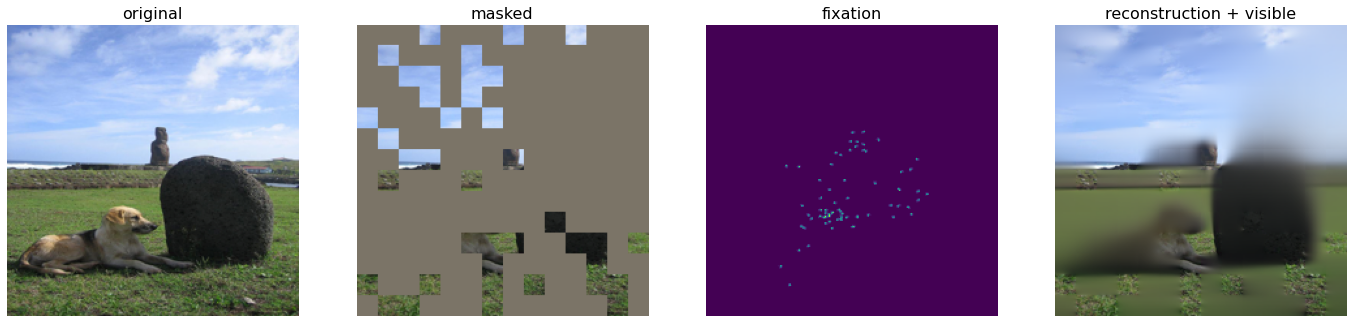

In [8]:
torch.cuda.manual_seed(10)
np.random.seed(10)
# randomly slected
img = process_image(img_url= r'C:\Users\marouane.tliba\saliency\MIT1003\MIT1003\stimuli\i12049788.jpeg')
fx_list, fx = process_fixmap(img_url= r'C:\Users\marouane.tliba\saliency\MIT1003\MIT1003\fix\i12049788_fixPts.jpg')
y,mask,x =run_one_image(img, model_mae.cuda(), mask_ratio= 0.80,fx= None)
vusulize_one_image(y, mask, x, fx)

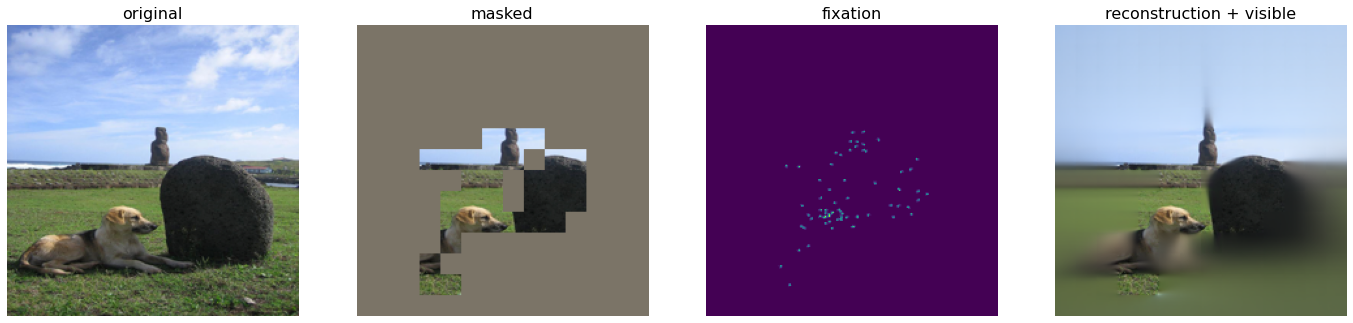

In [11]:
torch.cuda.manual_seed(10)
np.random.seed(10)
# Salient paches
img = process_image(img_url= r'C:\Users\marouane.tliba\saliency\MIT1003\MIT1003\stimuli\i12049788.jpeg')
fx_list, fx = process_fixmap(img_url= r'C:\Users\marouane.tliba\saliency\MIT1003\MIT1003\fix\i12049788_fixPts.jpg')
y,mask,x =run_one_image(img, model_mae.cuda(), mask_ratio= None,fx= fx_list, salient_ration=1., non_salient_ration=None,Mixed=False)
vusulize_one_image(y, mask, x, fx)

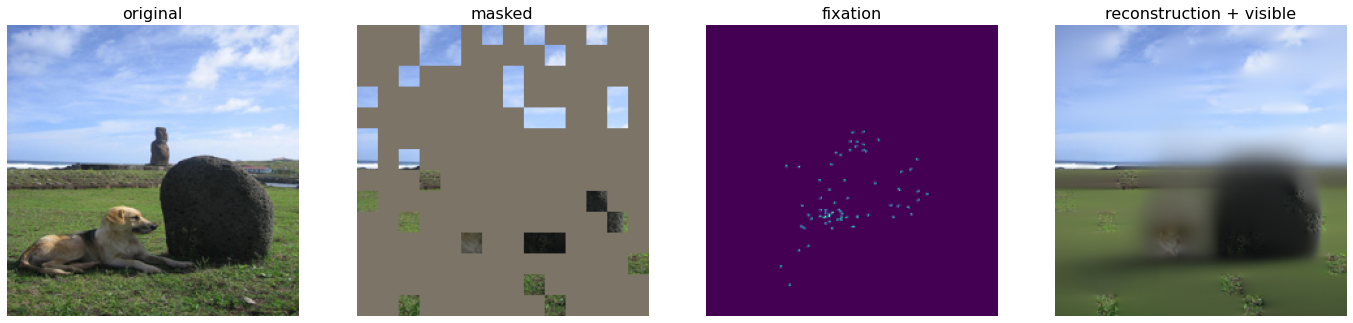

In [12]:
torch.cuda.manual_seed(10)
np.random.seed(10)
# None Salient paches
img = process_image(img_url= r'C:\Users\marouane.tliba\saliency\MIT1003\MIT1003\stimuli\i12049788.jpeg')
fx_list, fx = process_fixmap(img_url= r'C:\Users\marouane.tliba\saliency\MIT1003\MIT1003\fix\i12049788_fixPts.jpg')
y,mask,x =run_one_image(img, model_mae.cuda(), mask_ratio= None,fx= fx_list, salient_ration=None, non_salient_ration=1,Mixed=False)
vusulize_one_image(y, mask, x, fx)

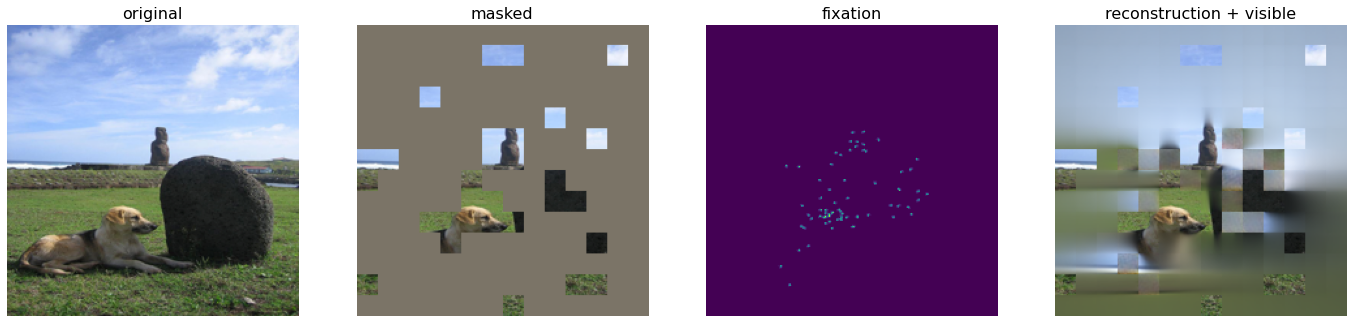

In [14]:
torch.cuda.manual_seed(10)
np.random.seed(10)
# 0.5 salient and 0.5 non salient
img = process_image(img_url= r'C:\Users\marouane.tliba\saliency\MIT1003\MIT1003\stimuli\i12049788.jpeg')
fx_list, fx = process_fixmap(img_url= r'C:\Users\marouane.tliba\saliency\MIT1003\MIT1003\fix\i12049788_fixPts.jpg')
y,mask,x =run_one_image(img, model_mae.cuda(), mask_ratio= None,fx= fx_list, salient_ration=0.5, non_salient_ration=0.5,Mixed=True)
vusulize_one_image(y, mask, x, fx)

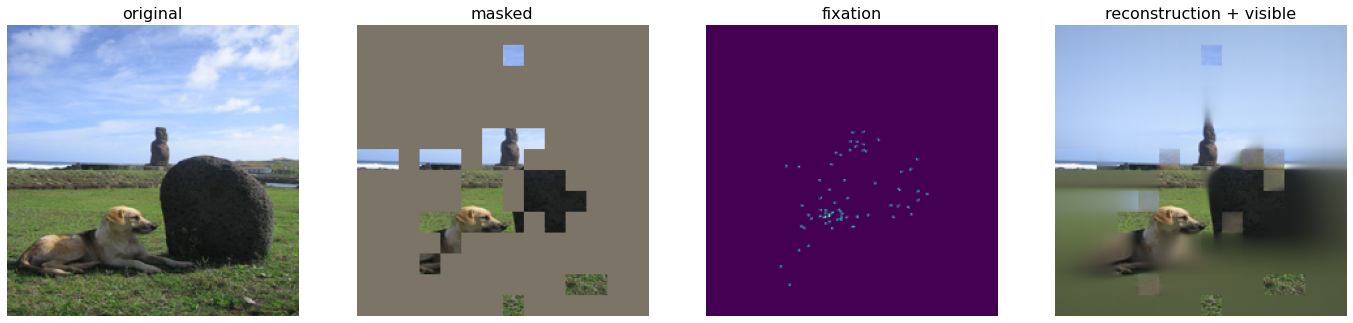

In [15]:
torch.cuda.manual_seed(10)
np.random.seed(10)
# 0.75 salient and 0.25 non salient
img = process_image(img_url= r'C:\Users\marouane.tliba\saliency\MIT1003\MIT1003\stimuli\i12049788.jpeg')
fx_list, fx = process_fixmap(img_url= r'C:\Users\marouane.tliba\saliency\MIT1003\MIT1003\fix\i12049788_fixPts.jpg')
y,mask,x =run_one_image(img, model_mae.cuda(), mask_ratio= None,fx= fx_list, salient_ration=0.75, non_salient_ration=0.25,Mixed=True)
vusulize_one_image(y, mask, x, fx)

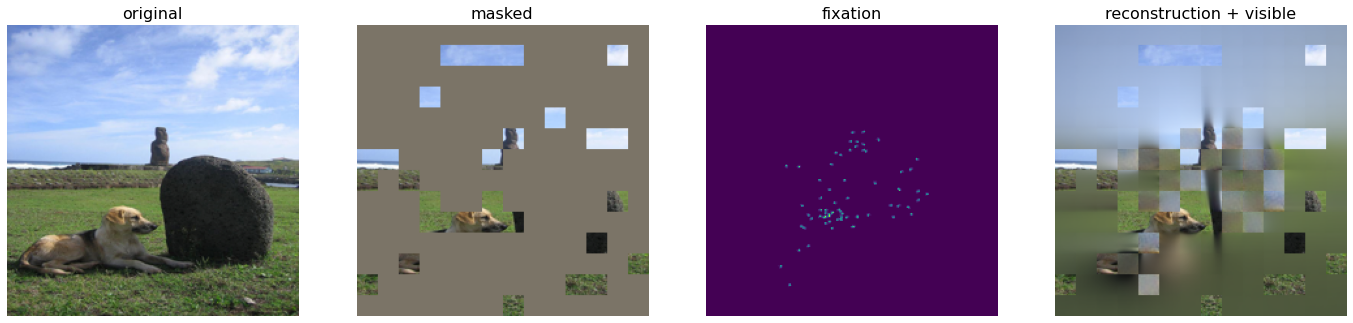

In [16]:
torch.cuda.manual_seed(10)
np.random.seed(10)
# 0.25 salient and 0.75 non salient
img = process_image(img_url= r'C:\Users\marouane.tliba\saliency\MIT1003\MIT1003\stimuli\i12049788.jpeg')
fx_list, fx = process_fixmap(img_url= r'C:\Users\marouane.tliba\saliency\MIT1003\MIT1003\fix\i12049788_fixPts.jpg')
y,mask,x =run_one_image(img, model_mae.cuda(), mask_ratio= None,fx= fx_list, salient_ration=0.25, non_salient_ration=0.75,Mixed=True)
vusulize_one_image(y, mask, x, fx)

100%|██████████| 1003/1003 [01:37<00:00, 10.27it/s]


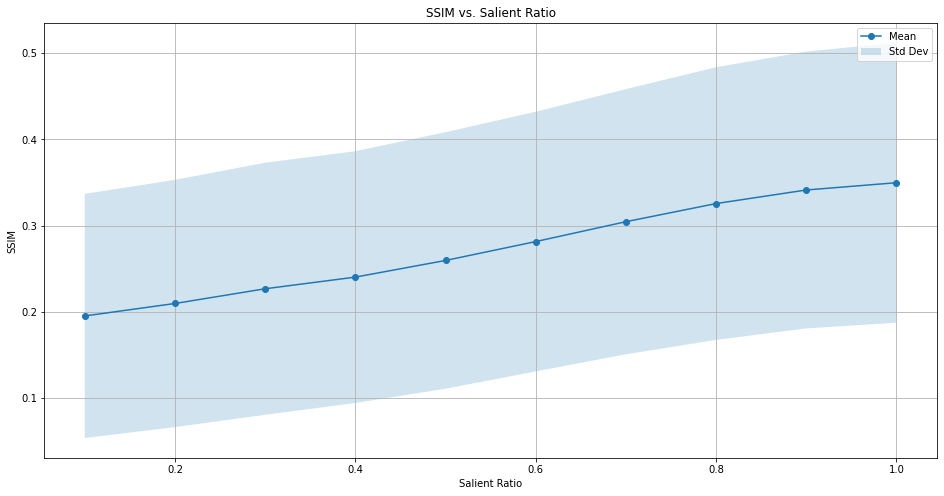

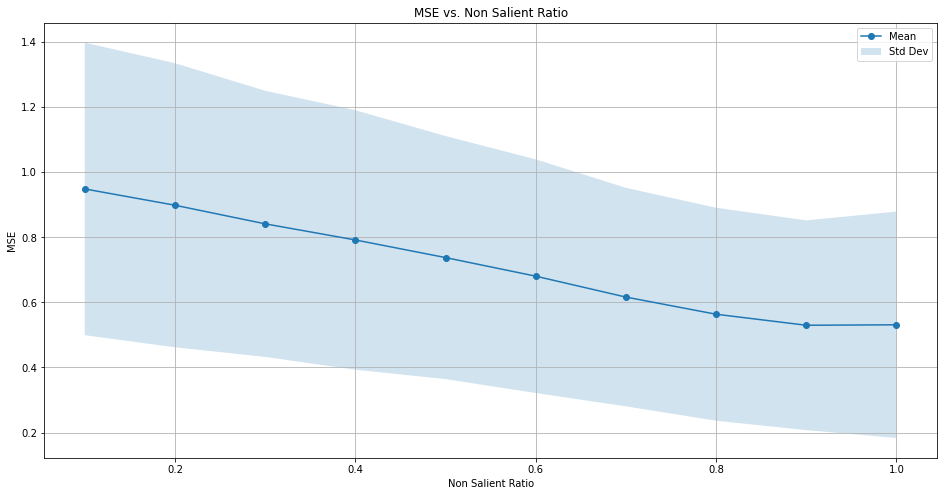

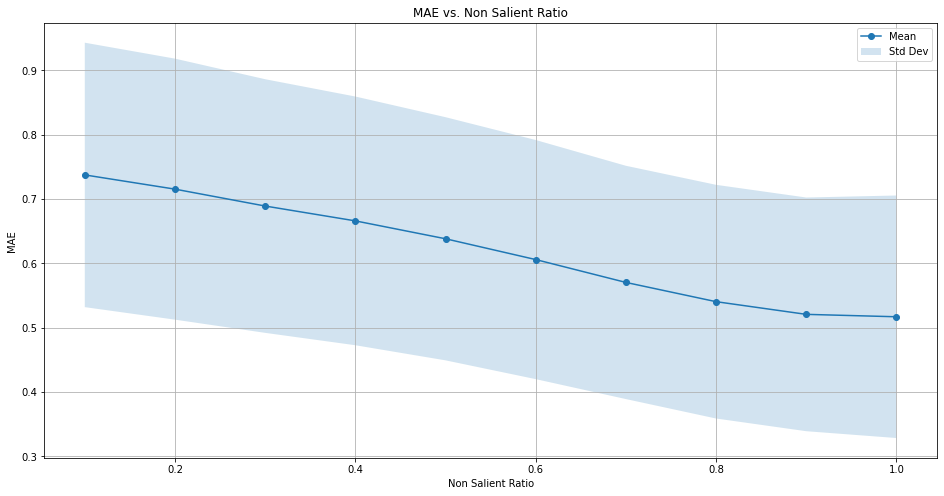

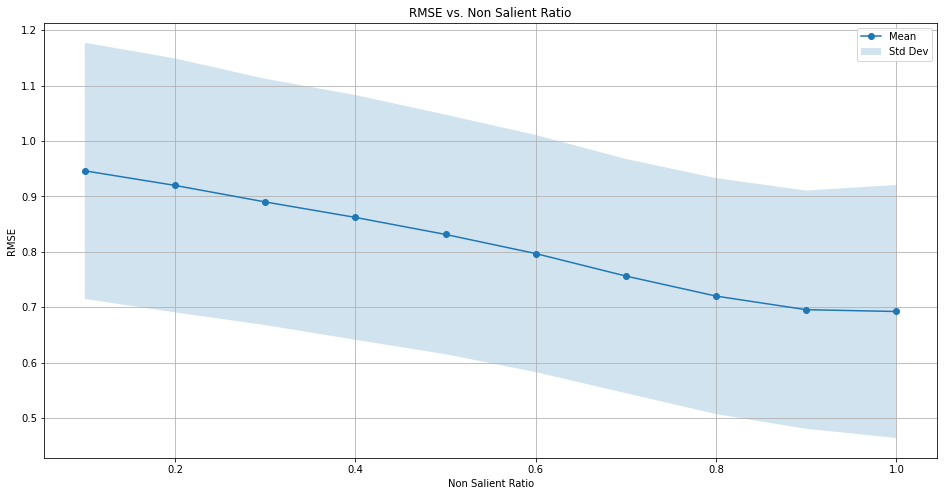

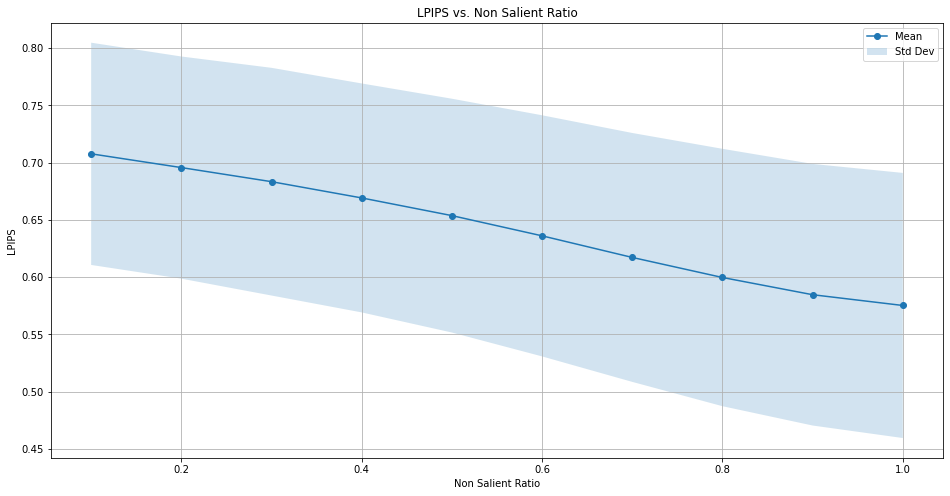

In [67]:
import os
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
from lpips import LPIPS

# Define the calculate_image_metrics function here (as shown in the previous responses)

# Set the directory paths for stimulus images and fixation maps
stimulus_dir = r'C:\Users\marouane.tliba\saliency\MIT1003\MIT1003\stimuli'
fixation_dir = r'C:\Users\marouane.tliba\saliency\MIT1003\MIT1003\fix'

# Define the values for salient_ratio to iterate over
salient_ratios = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6,0.7,0.8,0.9,1.0]

# Initialize lists to store metric scores for each combination of ratios
ssim_means = []
mse_means = []
rmse_means = []
mae_means = []
lpips_means = []
ssim_stds = []
mse_stds = []
rmse_stds = []
mae_stds = []
lpips_stds = []
ssim_mins = []
mse_mins = []
rmse_mins = []
mae_mins = []
lpips_mins = []
ssim_maxs = []
mse_maxs = []
rmse_maxs = []
mae_maxs = []
lpips_maxs = []

# List the files in the stimulus directory
stimulus_files = os.listdir(stimulus_dir)

# Iterate over each salient_ratio
for salient_ration in salient_ratios:
    # Initialize lists to store metric scores for this salient_ratio
    ssim_scores = []
    mse_scores = []
    rmse_scores = []
    mae_scores = []
    lpips_scores = []

    # Iterate over each stimulus file
    for stimulus_file in tqdm(stimulus_files):
        # Construct the full path to the stimulus image and fixation map
        stimulus_path = os.path.join(stimulus_dir, stimulus_file)
        fixation_file = os.path.splitext(stimulus_file)[0] + '_fixPts.jpg'  # Assuming fixation maps have a consistent naming convention
        fixation_path = os.path.join(fixation_dir, fixation_file)

        # Load and process the stimulus image and fixation map
        img = process_image(img_url=stimulus_path)
        fx_list, fx = process_fixmap(img_url=fixation_path)

        # Assuming you have a function run_one_image that processes the image and fixation map
        y, mask, x = run_one_image(img, model_mae.cuda(), fx_list, salient_ration=(salient_ration), non_salient_ration=(1-salient_ration),Mixed=True)

        # Calculate image metrics
        ssim_score, mse_score, rmse_score, mae_score, lpips_score = calculate_image_metrics(img, y)

        # Append the metric scores to the respective lists
        ssim_scores.append(ssim_score)
        mse_scores.append(mse_score)
        rmse_scores.append(rmse_score)
        mae_scores.append(mae_score)
        lpips_scores.append(lpips_score)

    # Convert the lists to numpy arrays for statistical calculations
    ssim_scores = np.array(ssim_scores)
    mse_scores = np.array(mse_scores)
    rmse_scores = np.array(rmse_scores)
    mae_scores = np.array(mae_scores)
    lpips_scores = np.array(lpips_scores)

    # Compute mean, standard deviation, minimum, and maximum for each metric
    ssim_mean = np.mean(ssim_scores)
    ssim_std = np.std(ssim_scores)
    ssim_min = np.min(ssim_scores)
    ssim_max = np.max(ssim_scores)

    mse_mean = np.mean(mse_scores)
    mse_std = np.std(mse_scores)
    mse_min = np.min(mse_scores)
    mse_max = np.max(mse_scores)

    rmse_mean = np.mean(rmse_scores)
    rmse_std = np.std(rmse_scores)
    rmse_min = np.min(rmse_scores)
    rmse_max = np.max(rmse_scores)

    mae_mean = np.mean(mae_scores)
    mae_std = np.std(mae_scores)
    mae_min = np.min(mae_scores)
    mae_max = np.max(mae_scores)

    lpips_mean = np.mean(lpips_scores)
    lpips_std = np.std(lpips_scores)
    lpips_min = np.min(lpips_scores)
    lpips_max = np.max(lpips_scores)

    # Append the computed statistics to the respective lists
    ssim_means.append(ssim_mean)
    mse_means.append(mse_mean)
    rmse_means.append(rmse_mean)
    mae_means.append(mae_mean)
    lpips_means.append(lpips_mean)
    ssim_stds.append(ssim_std)
    mse_stds.append(mse_std)
    rmse_stds.append(rmse_std)
    mae_stds.append(mae_std)
    lpips_stds.append(lpips_std)
    ssim_mins.append(ssim_min)
    mse_mins.append(mse_min)
    rmse_mins.append(rmse_min)
    mae_mins.append(mae_min)
    lpips_mins.append(lpips_min)
    ssim_maxs.append(ssim_max)
    mse_maxs.append(mse_max)
    rmse_maxs.append(rmse_max)
    mae_maxs.append(mae_max)
    lpips_maxs.append(lpips_max)

plt.figure(figsize=(16, 8))
plt.plot(salient_ratios, ssim_means, marker='o', label='Mean')
plt.fill_between(salient_ratios, np.array(ssim_means) - np.array(ssim_stds), np.array(ssim_means) + np.array(ssim_stds), alpha=0.2, label='Std Dev')
plt.xlabel('Salient Ratio')
plt.ylabel('SSIM')
plt.title('SSIM vs. Salient Ratio')
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(16, 8))
plt.plot(salient_ratios, mse_means, marker='o', label='Mean')
plt.fill_between(salient_ratios, np.array(mse_means) - np.array(mse_stds), np.array(mse_means) + np.array(mse_stds), alpha=0.2, label='Std Dev')
plt.xlabel('Non Salient Ratio')
plt.ylabel('MSE')
plt.title('MSE vs. Non Salient Ratio')
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(16, 8))
plt.plot(salient_ratios, mae_means, marker='o', label='Mean')
plt.fill_between(salient_ratios, np.array(mae_means) - np.array(mae_stds), np.array(mae_means) + np.array(mae_stds), alpha=0.2, label='Std Dev')
plt.xlabel('Non Salient Ratio')
plt.ylabel('MAE')
plt.title('MAE vs. Non Salient Ratio')
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(16, 8))
plt.plot(salient_ratios, rmse_means, marker='o', label='Mean')
plt.fill_between(salient_ratios, np.array(rmse_means) - np.array(rmse_stds), np.array(rmse_means) + np.array(rmse_stds), alpha=0.2, label='Std Dev')
plt.xlabel('Non Salient Ratio')
plt.ylabel('RMSE')
plt.title('RMSE vs. Non Salient Ratio')
plt.legend()
plt.grid()
plt.show()


plt.figure(figsize=(16, 8))
plt.plot(salient_ratios, lpips_means, marker='o', label='Mean')
plt.fill_between(salient_ratios, np.array(lpips_means) - np.array(lpips_stds), np.array(lpips_means) + np.array(lpips_stds), alpha=0.2, label='Std Dev')
plt.xlabel('Non Salient Ratio')
plt.ylabel('LPIPS')
plt.title('LPIPS vs. Non Salient Ratio')
plt.legend()
plt.grid()
plt.show()

